## 1. Requeriments

In [807]:
# import torch
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cpu.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

## 2. Import libraries

In [808]:
import torch
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import random

## 3. Graph building

### 3.1. Gene matrix

In [809]:
genes = pd.read_csv('../../../Data\PPT-Ohmnet/mRCC_big_pool/Second big pool/mrcc_protein_matrix_16_genes_6_nodes.csv')
Y = genes.Y

genes = genes.iloc[:,1:7] 
genes

,BAP1,EPAS1,NF2,PTEN,TSC1,VHL
0,33.677294,37.95811,33.96080,36.73944,32.93402,32.30615
1,32.643149,38.83281,33.69899,37.13114,33.16630,32.19988
2,32.368866,37.19345,34.07472,37.91878,33.63282,31.49147
3,31.895400,39.46713,33.14612,37.77827,32.88250,32.11538
4,33.968348,38.49884,32.58079,37.99008,33.44515,33.33646
...,...,...,...,...,...,...
176,33.843872,39.13826,33.58214,37.99666,32.93248,31.79913
177,32.519967,35.86338,33.10420,34.65038,32.62658,31.66344
178,33.115209,37.91340,33.80118,36.77314,32.81059,32.39461
179,32.895151,37.96870,33.51366,36.08937,34.04810,32.34561


In [810]:
scaler = preprocessing.MinMaxScaler()
names = genes.columns
d = scaler.fit_transform(genes)
genes = pd.DataFrame(d, columns=names)
genes

,BAP1,EPAS1,NF2,PTEN,TSC1,VHL
0,0.703386,0.614968,0.567742,0.655068,0.411780,0.681580
1,0.465055,0.796869,0.496606,0.717361,0.474109,0.664154
2,0.401843,0.455951,0.598694,0.842621,0.599295,0.547991
3,0.292727,0.928781,0.346389,0.820276,0.397955,0.650298
4,0.770463,0.727417,0.192786,0.853960,0.548936,0.850528
...,...,...,...,...,...,...
176,0.741776,0.860390,0.464858,0.855007,0.411366,0.598440
177,0.436667,0.179353,0.334999,0.322839,0.329281,0.576190
178,0.573847,0.605671,0.524372,0.660427,0.378658,0.696085
179,0.523132,0.617171,0.446251,0.551686,0.710731,0.688050


### 3.2. Graph edges

In [811]:
path ='../../../Data/PPT-Ohmnet/mRCC_big_pool/Second big pool/network_edges_mrcc_16_genes_6_nodes.tsv'
data = pd.read_csv(path, delimiter='\t')
edge_index1=data[data.columns[1]].to_numpy()
edge_index2=data[data.columns[2]].to_numpy()

In [812]:
edge_index = np.concatenate((edge_index1, edge_index2))

In [813]:
edge_index

array(['NF2', 'VHL', 'PTEN', 'TSC1', 'EPAS1', 'BAP1'], dtype=object)

In [814]:
le = preprocessing.LabelEncoder()
le.fit(edge_index)
len(list(le.classes_))

6

In [815]:
edge_index1 = le.transform(edge_index1)
edge_index2 = le.transform(edge_index2)

In [816]:
edge_index = [edge_index1]+[edge_index2]
edge_index = np.array(edge_index)

In [817]:
edge_index

array([[2, 5, 3],
       [4, 1, 0]])

In [818]:
edge_index = torch.tensor(edge_index, dtype=torch.int64)
edge_index

tensor([[2, 5, 3],
        [4, 1, 0]])

### 3.3. Create dataset

In [819]:
list_data_0=[]
list_data_1=[]
total_data=[]
for g in range(len(genes)):
  b=[]
  for i in genes.iloc[g].to_numpy():
    a=[]
    # a.append(Y[g])
    a.append(i*100)
    b.append(a)
  x = torch.tensor([b], dtype=torch.long).reshape([-1])
  edge_index = edge_index
  y = torch.tensor([Y.iloc[g]], dtype=torch.float).reshape([-1, 1])
  data = Data(x=x, edge_index=edge_index, y=y)
  total_data.append(data)
  if y == 0:
    list_data_0.append(data)
  else:
    list_data_1.append(data)

print(list_data_0[0])

Data(x=[6], edge_index=[2, 3], y=[1, 1])


C:\Users\sandr\AppData\Local\Temp/ipykernel_11852/1747583445.py:11: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  x = torch.tensor([b], dtype=torch.long).reshape([-1])


In [820]:
len(list_data_1)

96

### 3.4. Patient sample

In [821]:
data = list_data_0[0]
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of charcateristics per node: {data.num_features}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 6
Number of charcateristics per node: 1
Number of edges: 3
Average node degree: 0.50
Has isolated nodes: False
Has self-loops: False
Is undirected: False


## 4. Graph training

### 4.2. Training and testing the model

In [822]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.nn import SAGPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch import nn

In [823]:
embed_dim = 6

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()
        self.dim = dim
        super(Net, self).__init__()
        self.conv1 = GraphConv(embed_dim, dim)
        self.pool1 = SAGPooling(dim, ratio=0.1)
        self.conv2 = GraphConv(dim, dim)
        self.pool2 = SAGPooling(dim, ratio=0.1)
        self.item_embedding = torch.nn.Embedding(num_embeddings=101, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(192, 50)
        self.lin2 = torch.nn.Linear(500, 10)
        self.lin3 = torch.nn.Linear(50, 1)
        self.act1 = torch.nn.RReLU()
        print(self)

    def forward(self, x, edge_index, batch):
        x = torch.tensor(x) #.to(torch.int)
        # print(x.long())
        x = self.item_embedding(x)
        x = x.squeeze(1)

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        # x = F.relu(self.conv2(x, edge_index))
        # x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        # x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 #+ x2

        x = self.lin1(x)
        x = self.act1(x)
        # x = self.lin2(x)
        # x = self.act1(x)
        x = F.dropout(x, p=0.8, training=self.training)
        x = torch.sigmoid(self.lin3(x)).squeeze(1)
        return x


In [824]:
def train(epoch):
    model.train()
    criterion = nn.BCELoss()
    loss_all = 0
    for data in train_loader:
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all += loss.item() * data.num_graphs

    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data
        output = model(data.x, data.edge_index, data.batch)
        for i in range(len(output)):
            if output[i]>0.5:
                output[i]=1
            else:
                output[i]=0
            if output[i]==data.y[i]:
                correct=correct+1
    # print("Correct: "+str(correct) +" of "+str(len(loader.dataset)))
    return correct / len(loader.dataset)

In [825]:
from sklearn.model_selection import StratifiedKFold # import KFold
kf=StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

TRAIN:  [ 16  17  19  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 20 21]
162
19
Net(
  (conv1): GraphConv(6, 96)
  (pool1): SAGPooling(GraphConv, 96, ratio=0.1, multiplier=1.0)
  (conv2): GraphConv(96, 96)
  (pool2): SAGPooling(GraphConv, 96, ratio=0.1, multiplier=1.0)
  (item_embedding): Embedding(101, 6)
  (lin1): Linear(in_features=192, 

C:\Users\sandr\AppData\Local\Temp/ipykernel_11852/4148874623.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x) #.to(torch.int)


Epoch: 004, Loss: 0.7159, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 005, Loss: 0.7059, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 006, Loss: 0.7057, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 007, Loss: 0.7074, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 008, Loss: 0.7033, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 009, Loss: 0.7108, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 010, Loss: 0.7159, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 011, Loss: 0.7269, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 012, Loss: 0.7050, Train Acc: 0.4691, Test Acc: 0.4737
Epoch: 013, Loss: 0.7028, Train Acc: 0.4753, Test Acc: 0.4737
Epoch: 014, Loss: 0.7065, Train Acc: 0.4815, Test Acc: 0.4737
Epoch: 015, Loss: 0.6978, Train Acc: 0.4938, Test Acc: 0.4211
Epoch: 016, Loss: 0.7225, Train Acc: 0.5370, Test Acc: 0.3158
Epoch: 017, Loss: 0.7027, Train Acc: 0.5123, Test Acc: 0.3684
Epoch: 018, Loss: 0.6841, Train Acc: 0.5556, Test Acc: 0.3684
Epoch: 019, Loss: 0.7204, Train Acc: 0.5864, Test Acc: 0.3684
Epoch: 0

No handles with labels found to put in legend.


Epoch: 087, Loss: 0.4863, Train Acc: 0.6975, Test Acc: 0.4737
Epoch: 088, Loss: 0.4967, Train Acc: 0.7346, Test Acc: 0.4211
Epoch: 089, Loss: 0.4959, Train Acc: 0.7284, Test Acc: 0.4737
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  18  20
  21  30  32  33  34  40  41  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180] TEST: [16 17 19 22 23 24 25 26 27 28 29 31 35 36 37 38 39 42]
163
18
Net(
  (conv1): GraphConv(6, 96)
  (pool1): SAGPooling(GraphConv, 96, rati

No handles with labels found to put in legend.


Epoch: 086, Loss: 0.2768, Train Acc: 0.9080, Test Acc: 0.5000
Epoch: 087, Loss: 0.3387, Train Acc: 0.9264, Test Acc: 0.5000
Epoch: 088, Loss: 0.2822, Train Acc: 0.9018, Test Acc: 0.4444
Epoch: 089, Loss: 0.2974, Train Acc: 0.8896, Test Acc: 0.5556
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  31  35  36  37  38  39
  42  46  49  53  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180] TEST: [30 32 33 34 40 41 43 44 45 47 48 50 51 52 54 55 56 57]
163
18
Net(
  (conv

No handles with labels found to put in legend.


Epoch: 088, Loss: 0.2551, Train Acc: 0.8160, Test Acc: 0.6111
Epoch: 089, Loss: 0.2915, Train Acc: 0.8896, Test Acc: 0.6111
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  47  48  50  51  52  54  55  56
  57  72  73  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180] TEST: [46 49 53 58 59 60 61 62 63 64 65 66 67 68 69 70 71 74]
163
18
Net(
  (conv1): GraphConv(6, 96)
  (pool1): SAGPooling(GraphConv, 96, ratio=0.1, multiplier=1.0)
  (conv2): GraphConv(96, 96)
  (pool2):

No handles with labels found to put in legend.


Epoch: 087, Loss: 0.2057, Train Acc: 0.9325, Test Acc: 0.3889
Epoch: 088, Loss: 0.2335, Train Acc: 0.9387, Test Acc: 0.4444
Epoch: 089, Loss: 0.2141, Train Acc: 0.9448, Test Acc: 0.4444
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  74  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180] TEST: [72 73 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
163
18
Net(
  (conv1): GraphConv(6, 96)
  (pool1): SAGPooling(GraphConv, 96, rati

No handles with labels found to put in legend.


Epoch: 087, Loss: 0.5757, Train Acc: 0.6994, Test Acc: 0.6667
Epoch: 088, Loss: 0.5756, Train Acc: 0.6994, Test Acc: 0.6667
Epoch: 089, Loss: 0.5827, Train Acc: 0.7055, Test Acc: 0.6667
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90 108 109 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180] TEST: [ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 110]
163
18
Net(
  (conv1): GraphConv(6, 96)
  (pool1): SAGPooling(G

No handles with labels found to put in legend.


Epoch: 086, Loss: 0.4420, Train Acc: 0.7853, Test Acc: 0.4444
Epoch: 087, Loss: 0.4522, Train Acc: 0.7730, Test Acc: 0.4444
Epoch: 088, Loss: 0.4598, Train Acc: 0.7914, Test Acc: 0.4444
Epoch: 089, Loss: 0.4157, Train Acc: 0.8037, Test Acc: 0.4444
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 110 126 127 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180] TEST: [108 109 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 128]
1

No handles with labels found to put in legend.


Epoch: 089, Loss: 0.3871, Train Acc: 0.8466, Test Acc: 0.4444
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 128 142 144 145 146 147 148 149 150 151 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180] TEST: [126 127 129 130 131 132 133 134 135 136 137 138 139 140 141 143 152 153]
163
18
Net(
  (conv1): GraphConv(6, 96)
  (pool1): SAGPooling(GraphConv, 96, ratio=0.1, multiplier=1.0)
  (conv2): GraphConv(96, 96)
  (pool2): SAGPooling(GraphConv, 96, ratio=0.1, multip

No handles with labels found to put in legend.


Epoch: 088, Loss: 0.3617, Train Acc: 0.8221, Test Acc: 0.5556
Epoch: 089, Loss: 0.3565, Train Acc: 0.8405, Test Acc: 0.6667
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 143 152
 153 154 156 159 160 162 165 167 170 171 172 173 174 175 176 177 178 179
 180] TEST: [142 144 145 146 147 148 149 150 151 155 157 158 161 163 164 166 168 169]
163
18
Net(
  (conv1): GraphConv(6, 96)
  (pool1): SAGPooling(GraphConv, 96, ratio=0.1, multiplier=1.0)
  (conv2): GraphConv(

No handles with labels found to put in legend.


Epoch: 088, Loss: 0.4474, Train Acc: 0.8098, Test Acc: 0.3889
Epoch: 089, Loss: 0.4203, Train Acc: 0.8098, Test Acc: 0.3889
TRAIN:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 155 157 158 161 163 164 166 168
 169] TEST: [154 156 159 160 162 165 167 170 171 172 173 174 175 176 177 178 179 180]
163
18
Net(
  (conv1): GraphConv(6, 96)
  (pool1): SAGPooling(GraphConv, 96, ratio=0.1, multiplier=1.0)
  (conv2): GraphConv(

No handles with labels found to put in legend.


Epoch: 086, Loss: 0.4539, Train Acc: 0.7791, Test Acc: 0.5000
Epoch: 087, Loss: 0.4317, Train Acc: 0.7853, Test Acc: 0.5556
Epoch: 088, Loss: 0.4408, Train Acc: 0.7853, Test Acc: 0.5000
Epoch: 089, Loss: 0.3967, Train Acc: 0.7853, Test Acc: 0.4444
Test accuracy: 0.5140350877192983
Test stv: 0.0971605353260357


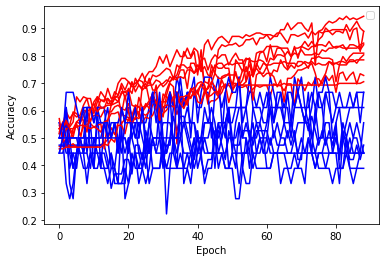

In [826]:
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

test_avg = []
for train_index, test_index in kf.split(total_data, Y):
    train_dataset=[]
    test_dataset=[]
    print("TRAIN: ", train_index, "TEST:", test_index)
    for i in train_index:
        train_dataset.append(total_data[i])
    for i in test_index:
        test_dataset.append(total_data[i])

    print(len(train_dataset))
    print(len(test_dataset))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    model = Net(dim=96)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=0.7) # 35 epochs

    train_epoch=[]
    test_epoch=[]
    epoch = 1
    train_acc=0
    while epoch < 90:
        loss = train(epoch)
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        train_epoch.append(train_acc)
        test_epoch.append(test_acc)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
            f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        epoch +=1

    plt.plot(train_epoch, color="red")
    plt.plot(test_epoch, color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    test_avg.append(test_acc)

print('Test accuracy: '+ str(np.array(test_avg).mean()))
print('Test stv: '+ str(np.array(test_avg).std()))